# Figure Two-point

## Import

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import sys
sys.path.append("../") # needed to bring in sdc module
import sdc_config5 as sdc
import sdc_config3 as sdc_np
import jax.numpy as jnp
import jax
# figures helper functions
%run figures_util.py
# from cleanplots import *

# CHOOSE GPU
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
gpu = 0

# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = str(1) # get more error messages
# ACTION: CHOOSE WHICH GPU TO USE (0-3)
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false' #stop jax from preallocating 75% of the gpu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System Parameters

In [3]:
wvmin = 450
wvmax = 800
wvstep = 6
downsample_factor = 1
wavelengths = np.arange(wvmin,wvmax+wvstep,wvstep)

mag_size = 4*9/39 # 4x followed by diffuser
spectral_camera_pixel_size = 2.4 # um
recon_pixel_size = spectral_camera_pixel_size*downsample_factor
gt_pixel_size = 4.4 # um
gt_mag_size = 4*0.38 # 4x followed by 0.38x tube lens
superpixel_size = 160 # um


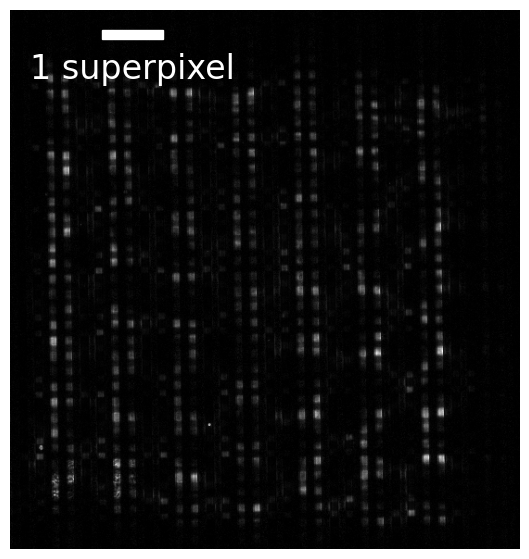

In [4]:

datafolder = '/media/azuldata/neerja/2023-11-16/5micron_green_bead_4x_60s_10db'
bg_name = 'bg.tiff'
gt_name = 'gt.tiff'
meas_name = 'meas_20micron.tiff' # shifted frame
meas_name2 = 'meas.tiff'  # original frame

crop_indices = [670,1252,1750,2300] #top bottom left default: [320,1652,1350,2726]

bits = 16
power = 1
sample_meas = (sdc.importTiff(datafolder,meas_name)/2**bits + sdc.importTiff(datafolder,meas_name2)/2**bits)
try:
    background = 2*sdc.importTiff(datafolder,bg_name)/2**bits # multipy background by 2 since using two images
except:
    print('No background image found, continuing without background subtraction')
    background = torch.zeros(sample_meas.shape)
measurement = sdc.cropci((sample_meas-background),crop_indices).clip(0,1)**power

fig,ax = plt.subplots(figsize = (7,7))

plt.imshow(measurement**1, cmap='gray')
# plt.colorbar()  
# plt.clim([0,.])
plt.axis('off')

scalebar = drawscalebar(ax, superpixel_size,spectral_camera_pixel_size)
ax.add_artist(scalebar)


(270.0, 334.0)

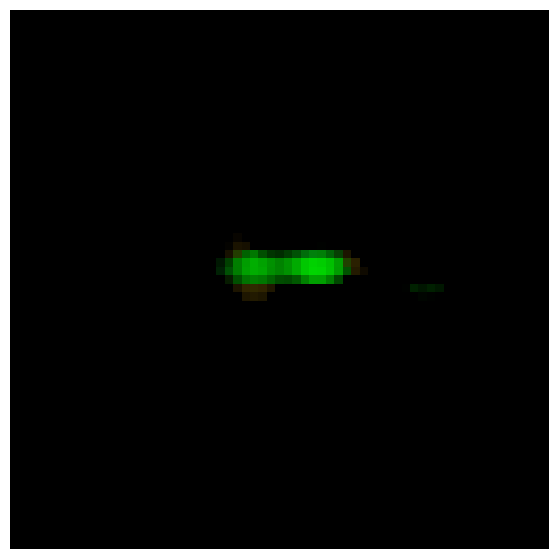

In [85]:
datafolder = '../Results/two_point/'

file = 'two-pointmeas_20micron.tiff_thr=6e-06_xytv=0_lamtv=0_kmax=10000_stepsize=0.1_downsample=1.npy'
skip = [0]

xk = np.load(os.path.join(datafolder, file))
HSI_data = np.transpose(xk, (1,2,0))
HSI_data = np.reshape(HSI_data, [-1,xk.shape[0]])
false_color = sdc_np.HSI2RGB(wavelengths, HSI_data ,xk.shape[1],xk.shape[2], 65, False)

# Display the image with boxes and labels
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(false_color)
plt.axis('off')
xcen = 255
ycen = 302

plt.xlim([xcen -32,xcen+32])
plt.ylim([ycen-32,ycen+32])




[252 259]


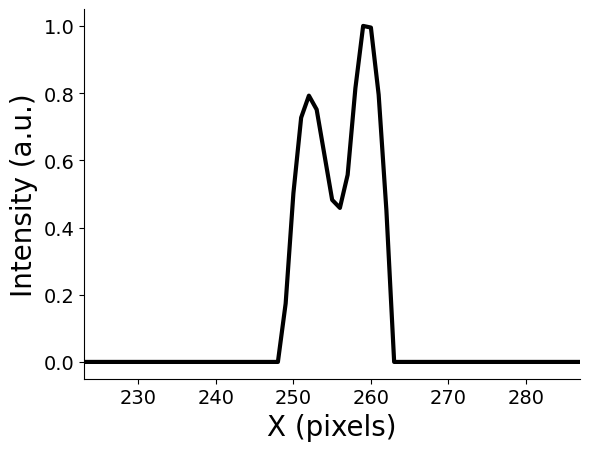

In [86]:
%matplotlib inline
cross_line = false_color[302,:,1]
# normalize the cross line
cross_line = cross_line/np.amax(cross_line)

plt.plot(cross_line, linewidth = 3, color = 'black')
plt.xlim([xcen -32,xcen+32])
plt.xlabel('X (pixels)',  fontsize=20)
plt.ylabel('Intensity (a.u.)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

import scipy.signal
#label peaks
# Find the peaks in the data
peaks, _ = scipy.signal.find_peaks(cross_line)
print(peaks)





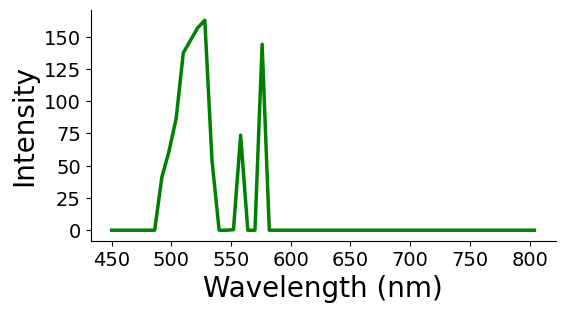

In [101]:
spectra = xk[:,ycen,xcen-3]
plt.figure(figsize=(6, 3))

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Intensity', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(wavelengths, spectra,'green',linewidth=2.5)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## white PSF autocorrelation

In [7]:
# compute the autocorrelation of the psf
calibration_location = '../'
psf_name = 'recon_materials_organized/psf_2023-11-16.pt'
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
plt.imshow(sensor_psf,cmap ='gray')
plt.axis('off')
plt.colorbar()

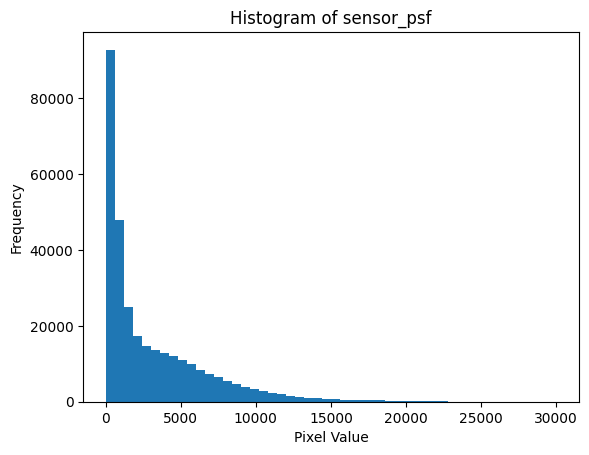

In [13]:
import matplotlib.pyplot as plt

# Flatten the sensor_psf array
sensor_psf_flat = sensor_psf.flatten()

# Plot the histogram
plt.hist(sensor_psf_flat, bins=50)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of sensor_psf')
plt.show()


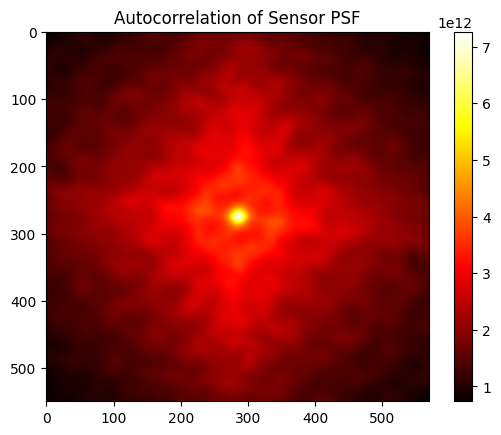

In [8]:
from scipy.signal import correlate

# Compute the autocorrelation of the psf
autocorr = correlate(sensor_psf, sensor_psf, mode='same')

# Plot the autocorrelation
plt.imshow(autocorr, cmap='hot')
plt.colorbar()
plt.title('Autocorrelation of Sensor PSF')
plt.show()

[135 228 285 342 435]
25


(235.0, 335.0)

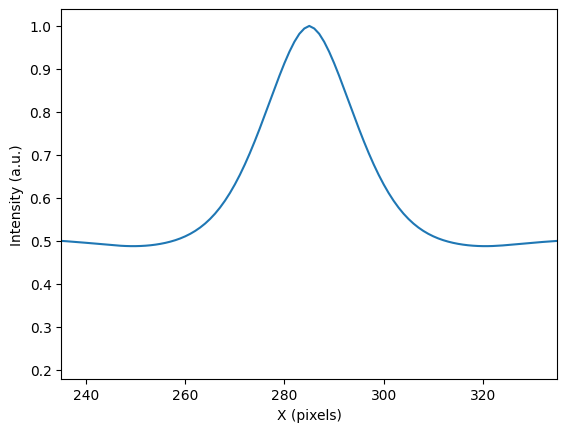

In [30]:
# %matplotlib inline
# normalize
autocorr = autocorr/autocorr.max()
psf_autocorr = autocorr[autocorr.shape[0]//2,:]
plt.plot(psf_autocorr)
# plt.xlim([psf_autocorr.shape[0]//2-100,psf_autocorr.shape[0]//2+100])
plt.xlabel('X (pixels)')
plt.ylabel('Intensity (a.u.)')
import scipy.signal as signal

# Find the peaks in the autocorr
peaks, _ = signal.find_peaks(psf_autocorr)
print(peaks)
peakind = 285
res_criteria = 0.7
bool = psf_autocorr>res_criteria
peakwidth = sum(bool)
print(peakwidth)
plt.xlim([peakind-peakwidth*2,peakind+peakwidth*2])

## Compute theoretical resolution using cross correlation instead


In [51]:
calibration_location = '../'
psf_name = 'recon_materials_organized/psf_2023-11-16.pt'
filter_cube_file = 'Calibration_data/spectral_calibration_2024-02-23_8nmFWHM.pt'  # 'filter_stack' # use new one from 2024


# Load and crop PSF
sensor_psf = torch.load(os.path.join(calibration_location, psf_name),map_location='cpu')
ccrop = torchvision.transforms.CenterCrop(spectral_filter.shape[1:]) # center the psf
psf = ccrop(sensor_psf)
psf = psf.clip(0) # clip negative values to 0
psf = psf/torch.sum(psf) # l1 normalize the psf
hpad = sdc.pad(psf) # normalize
hfftpad = torch.fft.fft2(hpad)

# Load and crop filter cube
spectral_filter_data = torch.load(os.path.join(calibration_location,filter_cube_file),map_location='cpu')
filterstack = sdc.cropci(spectral_filter_data['filter_stack'], crop_indices)
wv = torch.Tensor(spectral_filter_data['wavelength'])
msum = sdc.sumFilterArray(filterstack,wv,wvmin,wvmax,wvstep)
spectral_filter = msum/torch.amax(msum)

806


## Compute xhsift around 550 nm 

In [ ]:
# simulate an object with an impulse function
ind_steps = 100
NL, NY, NX = spectral_filter.shape
ystack = torch.zeros(ind_steps,NY,NX)
for k in range(ind_steps):
    x0 = torch.zeros_like(spectral_filter)
    x0[int(NL/2),int(NY/2)+k,int(NX/2)] = 1 # only step along x
    y0 = sdc.forwardmodel3d(x0,hfftpad,spectral_filter)
    ystack[k,:,:] = y0


(0.0, 100.0)

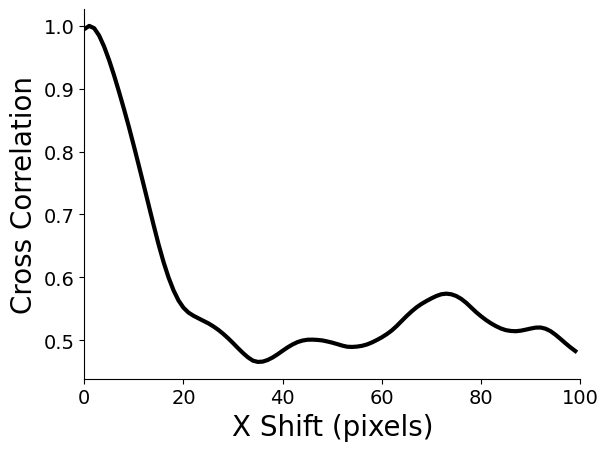

In [73]:
# compute inner product
y0 = ystack[0,:,:]
inner_prod = torch.zeros(ind_steps)
for k in range(ind_steps):
    ystep = ystack[k,:,:]
    inner_prod[k] = torch.sum(y0*ystep)

inner_prod = inner_prod/torch.max(inner_prod)

plt.plot(inner_prod, linewidth = 3, color = 'black')
plt.xlabel('X Shift (pixels)',  fontsize=20)
plt.ylabel('Cross Correlation',  fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Turn off the box
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim([0,ind_steps])

Text(0, 0.5, 'Measurement Sum')

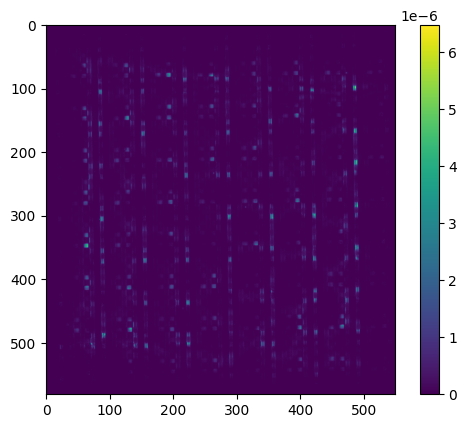

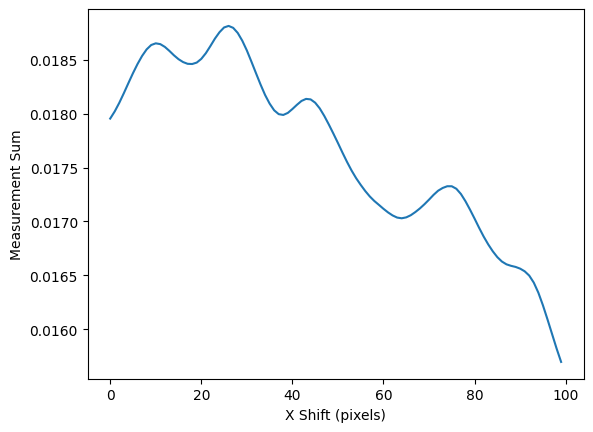

In [63]:
# plot measurement sum

plt.figure()
plt.imshow(torch.sum(x0,dim = 0))
plt.imshow(y0)
# plt.clim([0,1000])
plt.colorbar()

s = torch.sum(ystack,dim = [1,2])
plt.figure()
plt.plot(s)
plt.xlabel('X Shift (pixels)')
plt.ylabel('Measurement Sum')